# Importing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import math
from sklearn.metrics import mean_squared_error

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# preparing data

In [3]:
def prepare_dataset(data):
  
  open_price = np.array(data['Open Price'])
  high_price = np.array(data['High Price'])
  low_price = np.array(data['Low Price'])
  close_price = np.array(data['Close Price'])

  observation_dim1 = (close_price - open_price) / open_price
  observation_dim2 = (high_price - open_price) / open_price
  observation_dim3  = (open_price - low_price) / open_price
  
  dataset = np.column_stack((observation_dim1,observation_dim2,observation_dim3))
  return dataset

In [4]:
dataset_path = '/content/drive/MyDrive/machine_learning_project/Tata-steel.csv'
dataset = pd.read_csv(dataset_path)

train_data, test_data = train_test_split(dataset, test_size=0.2, shuffle=False)
print(f"shape of train data: {train_data.shape}")
print(f"shape of test data: {test_data.shape}")

shape of train data: (1188, 13)
shape of test data: (297, 13)


In [5]:
train_data_processed = prepare_dataset(train_data)
test_data_processed = prepare_dataset(test_data)

print(f"shape of processed train data: {train_data_processed.shape}")
print(f"shape of processed test data: {test_data_processed.shape}")

shape of processed train data: (1188, 3)
shape of processed test data: (297, 3)


In [6]:
def create_time_series_data(dataset,time_step):
  Xdata = []
  Ydata= []
  for i in range(len(dataset)-time_step):

    start_index = i
    end_index = i + time_step
    Xdata.append(dataset[start_index:end_index, :]) #(1465,20,3)
    Ydata.append(dataset[i+1, :])   #(1465, 3)
    
  
  Xdata = np.array(Xdata)
  Ydata = np.array(Ydata)

  return Xdata,Ydata

In [7]:
time_step = 10
time_series_trainX,time_series_trainY = create_time_series_data(train_data_processed,time_step)
time_series_testX,time_series_testY = create_time_series_data(test_data_processed,time_step)

print('time series train X:',time_series_trainX.shape)
print('time series train y:',time_series_trainY.shape)

print('time series test X:',time_series_testX.shape)
print('time series test y:',time_series_testY.shape)

time series train X: (1178, 10, 3)
time series train y: (1178, 3)
time series test X: (287, 10, 3)
time series test y: (287, 3)


# creating LSTM model

In [8]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_series_trainX.shape[1],time_series_trainX.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(100))
model.add(Dense(3))
model.compile(loss='mean_squared_error',optimizer='adam')

# Evaluation

In [9]:
test_predict=model.predict(time_series_testX)
print(mean_squared_error(time_series_testY,test_predict))

0.0005943173272028562


In [10]:
outcome0 = test_predict[:,0].reshape(-1,1)
outcome1 = test_predict[:,1].reshape(-1,1)
outcome2 = test_predict[:,2].reshape(-1,1)

open_price = np.array(test_data.iloc[:len(test_data)-time_step,:]['Open Price']).reshape(-1,1)
close_price_predictions = open_price * (1 + outcome0)
high_price_predictions = open_price * (1 + outcome1)
low_price_predictions = open_price * (1 + outcome2)

col1 = np.array(test_data.iloc[:len(test_data)-time_step,:]['Close Price']).reshape(-1,1)
col2 = np.array(test_data.iloc[:len(test_data)-time_step,:]['High Price']).reshape(-1,1)
col3 = np.array(test_data.iloc[:len(test_data)-time_step,:]['Low Price']).reshape(-1,1)
ground_truth = np.concatenate((col1,col2,col3),axis=1)

close_price_predictions = np.array(close_price_predictions).reshape(-1,1)
high_price_predictions = np.array(high_price_predictions).reshape(-1,1)
low_price_predictions = np.array(low_price_predictions).reshape(-1,1)
predicted = np.concatenate((close_price_predictions,high_price_predictions,low_price_predictions),axis=1)

print(mean_squared_error(ground_truth,predicted))

273.70960521145537


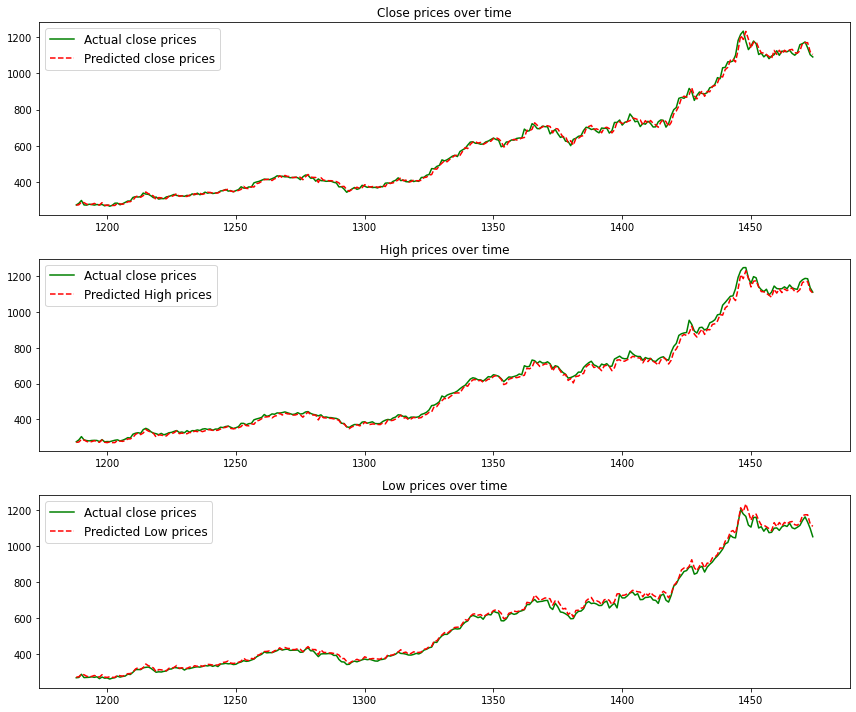

In [11]:
fig = plt.figure(1, figsize=(12,10))

x_axis = np.array(test_data.index[0:test_data.shape[0]-time_step])

plt.subplot(3,1,1)
plt.plot(x_axis, col1, 'g', label="Actual close prices")
plt.plot(x_axis, close_price_predictions, 'r--', label="Predicted close prices")
plt.legend(prop={'size': 12})
plt.title('Close prices over time')

plt.subplot(3,1,2)
plt.plot(x_axis, col2, 'g', label="Actual close prices")
plt.plot(x_axis, high_price_predictions, 'r--', label="Predicted High prices")
plt.legend(prop={'size': 12})
plt.title('High prices over time')

plt.subplot(3,1,3)
plt.plot(x_axis, col3, 'g', label="Actual close prices")
plt.plot(x_axis, low_price_predictions, 'r--', label="Predicted Low prices")
plt.legend(prop={'size': 12})
plt.title('Low prices over time')
plt.tight_layout()
plt.show()